# Objetivos

O objetivo desse trabalho é mostrar oque foi aprendido na lissão 1 do curso de fast ai. Além de confirmar a raça do meu cachorro.

# Tema

O tema do artigo é **diferenciar um cachorro qualquer de um Yorkshire**. A inspiração desse tema é o meu cachorro, pois embora ele seja um yorkshire (eu conheci os pais dele então não há dúvida) ele não tem as características únicas de um. Isso acaba dificultando o reconhecimento da raça dele por outras pessoas, então vamos ver se a IA consegue diferenciar.

# Ambiente de trabalho

Primeiramente vamos configurar o ambiente de trabalho. Lembrando que é importante ter o pip instalado na sua máquina.

Como vamos usar a biblioteca do FastAi, temos que atualizá-la. Também utilizaremos o DuckDuckGo para conseguir imagens para processamento.

In [9]:
!pip install -Uqq fastai
!pip install -Uqq fastai duckduckgo_search

# Download de imagens

Agora, vamos definir a pesquisa no DuckDuckGo com base em um termo que será definido posteriormente.

In [10]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def PesquisaDuckDuckGo(term, max_images=30):
    print(f"Pesquisando por '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Neste momento vamos ver os resultados da pesquisa ao pesquisar por "Yorkshire cachorro"....

Pesquisando por 'Yorkshire cachorro'


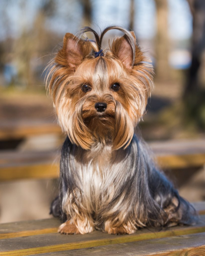

In [20]:
from fastdownload import download_url
from fastai.vision.all import *

urls = PesquisaDuckDuckGo('Yorkshire cachorro', max_images=1)
urls[0]

dest = 'Yorkshire.jpg'
download_url(urls[0], dest, show_progress=False)

imagem = Image.open(dest)
imagem.to_thumb(256,256)

 ...e agora só por "Cachorro".

Pesquisando por 'Cachorro'


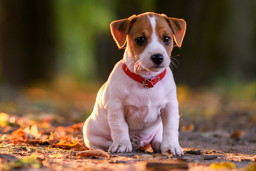

In [23]:
urls = PesquisaDuckDuckGo('Cachorro', max_images=1)
urls[0]

dest2 = 'Cachorro.jpg'
download_url(urls[0], dest2, show_progress=False)


imagem = Image.open(dest2)

imagem.to_thumb(256,256)

Agora que podemos pegar os dois tipos de resultados diferentes, vamos criar as pastas onde eles serão alocados. O nome da pasta será 'AchaARaça'.

In [28]:
Pesquisa = 'Yorkshire cachorro','Cachorro'
path = Path('AchaARaça')
from time import sleep

for o in Pesquisa:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=PesquisaDuckDuckGo(o, max_images=50))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Pesquisando por 'Yorkshire cachorro'


/home/antogalatic/.local/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Pesquisando por 'Cachorro'


Os erros em algumas imagens que podem ser gerados nessa etapa podem ser ignorados, pois as imagens corrompidas serão removidas depois.

# Treinamento da rede

Agora que temos nossos dados devidamente classificados e separados em nossa máquina, devemos treinar a rede para que ela possa entender a diferença entre um Yorkshire e um cachorro normal.

Para isso, devemos começar por remover as fotos que possam não ter baixado corretamente.

In [29]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

Após a remoção das imagens corrompidas, podemos iniciar o desenvolvimento das *DataLoaders* que são os conjuntos de dados que serão usados para treinar e validar o modelo. Como estamos utilizando o FastAI, isso é possível de fazer com os *DataBlocks*.

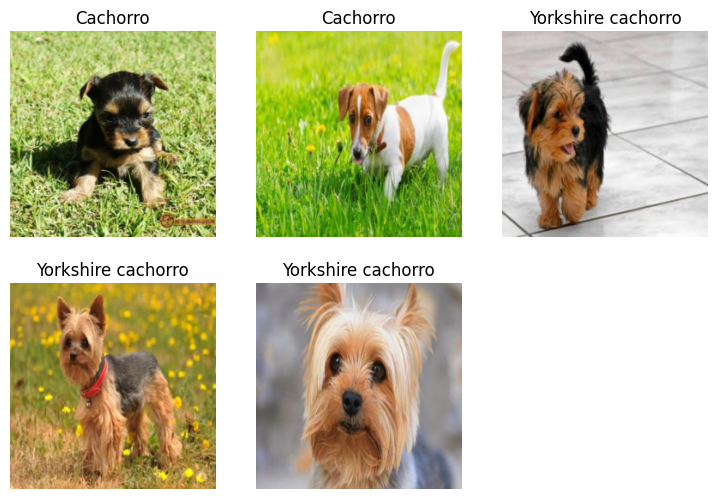

In [34]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(240, method='squish')]
).dataloaders(path, bs=25)

dls.show_batch(max_n=5)

Nesse *DataLoader* é separado um grupo de 20% dos dados previamente coletados para serem dados de validação, e cada imagem é re-modelada para 240px, pois o tamanho da imagem não importa muito na hora do processamento.

É importante dizer que quando eu fiz com 192px como no exemplo do curso pela primeira vez eu recebi um erro dizendo que minha gpu é muito antiga. Porém quando executei o mesmo comando de novo, esse erro não aconteceu mais...

Agora que os *DataLoaders* estão configurados, vamos enserí-los em uma modelo já pré-treinado disponibilizado pelo FastAI.

In [35]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/antogalatic/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/antogalatic/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/antogalatic/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.824295,0.115009,0.052632,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.250068,0.071369,0.052632,00:06
1,0.142719,0.019382,0.000000,00:06
2,0.094160,0.013796,0.000000,00:06


Utilizaremos a resnet18 para esse primeiro modelo.

# Usar o modelo

Agora que criamos e treinamos um modelo podemos testá-lo para ver se ele realmente funciona

Isso é um: Yorkshire cachorro.
Probabilidade de ser um Yorkshire: 1.0000


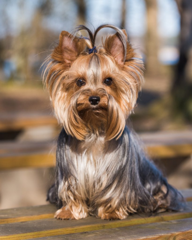

In [47]:
nomeIMG = 'Yorkshire.jpg'
is_Yorkshire,_,probs = learn.predict(PILImage.create(nomeIMG))
print(f"Isso é um: {is_Yorkshire}.")
print(f"Probabilidade de ser um Yorkshire: {probs[1]:.4f}")
Image.open(nomeIMG).to_thumb(240,240)

Isso é um: Cachorro.
Probabilidade de ser um Yorkshire: 0.0002


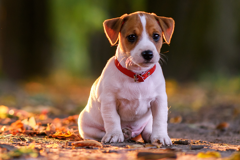

In [48]:
nomeIMG = 'Cachorro.jpg'
is_Yorkshire,_,probs = learn.predict(PILImage.create(nomeIMG))
print(f"Isso é um: {is_Yorkshire}.")
print(f"Probabilidade de ser um Yorkshire: {probs[1]:.4f}")
Image.open(nomeIMG).to_thumb(240,240)

Como visto anteriormente, essas eram as duas primeiras imagens baixadas para ver se a pesquisa era correta. E como esperado, o modelo conseguiu diferenciá-las corretamente.

Agora que sabemos que o modelo funciona, eu posso testar com meu próprio cachorro, e ver se o sistema encherga ele como Yorkshire ou como um cachorro qualquer.

Isso é um: Yorkshire cachorro.
Probabilidade de ser um Yorkshire: 0.9987


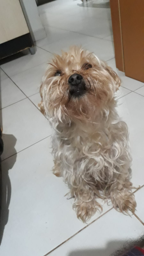

In [50]:
nomeIMG = 'Bidu.jpg'
is_Yorkshire,_,probs = learn.predict(PILImage.create(nomeIMG))
print(f"Isso é um: {is_Yorkshire}.")
print(f"Probabilidade de ser um Yorkshire: {probs[1]:.4f}")
Image.open(nomeIMG).to_thumb(256,256)

Pronto! Por fim é possível afirmar que **meu cachorro é sim um Yorkshire** com base na IA desenvolvida neste artigo.